<a href="https://colab.research.google.com/github/SanjaPanda/car-plate-detector/blob/main/Detecting_Lisence_Plate_Number.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing important libraries and packages

1. object-detection api
2. Tesseract - ocr
3. OCRopus

In [ ]:
%cd '/content/drive/MyDrive/car-plate-detector/models/research/'

!cp object_detection/packages/tf2/setup.py .
!python -m pip install .

/content/drive/MyDrive/car-plate-detector/models/research
Processing /content/drive/My Drive/car-plate-detector/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1618454 sha256=094d3d68812ffa26d0e4bb22cd20f5c52621e4bd07a97e355adf2954970ecb82
  Stored in directory: /tmp/pip-ephem-wheel-cache-m60j1pq9/wheels/e5/ea/c3/2df533acf552d9794e00a66f3c70bd704d5f3ba32f729cb2a8
Successfully built object-detection
  Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [ ]:
!sudo apt update
!sudo apt install tesseract-ocr
!sudo apt install libtesseract-dev
!pip install pytesseract

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree     

In [ ]:
%cd '/content/drive/MyDrive/car-plate-detector/'

try:
  shutil.rmtree('ocropy')
  print('ocropy file deleted')
except:
  pass

!git clone https://github.com/ocropus/ocropy.git

/content/drive/MyDrive/car-plate-detector
fatal: destination path 'ocropy' already exists and is not an empty directory.


In [ ]:
%cd '/content/drive/MyDrive/car-plate-detector/ocropy'
!sudo apt-get install $(cat PACKAGES)
!wget -nd https://github.com/zuphilip/ocropy-models/raw/master/en-default.pyrnn.gz
!mv en-default.pyrnn.gz models/
!sudo python2 setup.py install
!ocropus-nlbin --help

/content/drive/MyDrive/car-plate-detector/ocropy
Reading package lists... Done
Building dependency tree       
Reading state information... Done
python-matplotlib is already the newest version (2.1.1-2ubuntu3).
python-scipy is already the newest version (0.19.1-2ubuntu1).
python-lxml is already the newest version (4.2.1-1ubuntu0.3).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
--2021-02-13 19:00:54--  https://github.com/zuphilip/ocropy-models/raw/master/en-default.pyrnn.gz
Resolving github.com (github.com)... 192.30.255.113
Connecting to github.com (github.com)|192.30.255.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zuphilip/ocropy-models/master/en-default.pyrnn.gz [following]
--2021-02-13 19:00:54--  https://raw.githubusercontent.com/zuphilip/ocropy-models/master/en-default.pyrnn.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.1

# Importing Model

In [ ]:
#Importing important libraries

import shutil
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import cv2
from PIL import Image as im
import matplotlib.pyplot as plt
import warnings
import pytesseract
import numpy as np
import glob

## Recognising Lisence Plate

In [ ]:
# Load saved model and build the detection function
detect_fn=tf.saved_model.load("/content/drive/MyDrive/car-plate-detector/workspace/training_demo/exported-models/my_model_ssd/saved_model")
print('Loaded Model')

category_index=label_map_util.create_category_index_from_labelmap("/content/drive/MyDrive/car-plate-detector/workspace/training_demo/annotations/label_map.pbtxt")

Loaded Model


In [ ]:
#Loading the image
%cd '/content/drive/MyDrive/car-plate-detector/'

warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

img_paths = [i for i in glob.glob('/content/drive/MyDrive/car-plate-detector/workspace/training_demo/images/test/*.png')]


/content/drive/MyDrive/car-plate-detector


In [ ]:
def load_image_into_numpy_array(path):
  
    img = cv2.imread(path)
    if img.shape[2] == 4:
      print('Changed Image')
      img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    return np.array(img), img

In [ ]:
def clean_img(imge):
  
  imge = cv2.cvtColor(imge, cv2.COLOR_BGR2GRAY)
  imge = cv2.resize(imge, None, fx = 3, fy = 3, interpolation = cv2.INTER_NEAREST)
  imge = cv2.GaussianBlur(imge, (5,5), 0) 
  imge = cv2.medianBlur(imge, 3)
  return imge

In [ ]:
def find_plate_num(imge):
  
  plate_num = pytesseract.image_to_string(imge, lang='eng', config='--psm 13 -c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ ')
  plate_num_clean = ''.join(map(str,[i.upper() for i in plate_num if i.isalnum() or i == ' ']))
  return plate_num_clean

In [ ]:
def plate_num_detection(image_path):
    pl_num = []
    coord = []
    image_np, img = load_image_into_numpy_array(image_path)
    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor=tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor=input_tensor[tf.newaxis, ...]

    # input_tensor = np.expand_dims(image_np, 0)
    detections=detect_fn(input_tensor)

    # We're only interested in the first num_detections.

    num_detections=int(detections.pop('num_detections'))

    detections={key:value[0,:num_detections].numpy()
                   for key,value in detections.items()}

    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    count = 0
    plate_num_clean = ''
    while detections['detection_scores'][count] > 0.6:

      boxes = detections['detection_boxes'][count]
      height, width, channel = image_np.shape
      ymin = int((boxes[0]*height)+3)
      xmin = int((boxes[1]*width)+3)
      ymax = int((boxes[2]*height)-3)
      xmax = int((boxes[3]*width)-3)

      cropped_img = img[ymin:ymax, xmin:xmax]
      res_img = clean_img(cropped_img)
      cv2.imwrite('/content/drive/MyDrive/car-plate-detector/result/res_crop.png',res_img)
      
      !ocropus-nlbin -n result/res_crop.png -o result/bin_img > result/log1.txt
      res_img2 = cv2.imread('/content/drive/MyDrive/car-plate-detector/result/bin_img/0001.bin.png')

      plate_num = find_plate_num(res_img2)
      pl_num.append(plate_num)
      coord.append((xmin+5, ymin+5))
      
      print('\nPlate Num: ',plate_num)
      count = count+1

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np,
          detections['detection_boxes'],
          detections['detection_classes'],
          detections['detection_scores'],
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=count,     
          min_score_thresh=.6,   
          agnostic_mode=False)
    
    for n,i in enumerate(pl_num):
      print(coord[n])
      image_np = cv2.putText(image_np,i,coord[n],cv2.FONT_HERSHEY_SIMPLEX ,1,(255, 255, 0),2, cv2.LINE_AA)

    return image_np

/usr/local/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)

Plate Num:  WI WAT ZF
(160, 176)


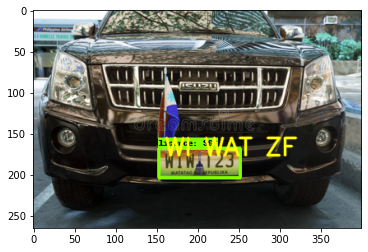

/usr/local/lib/python2.7/dist-packages/scipy/ndimage/interpolation.py:605: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)

Plate Num:  SUP GAS
(117, 193)


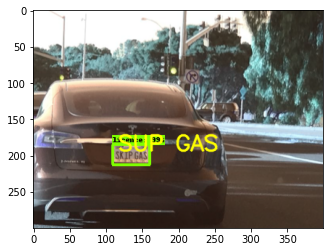


Plate Num:  S7TIDW
(362, 125)


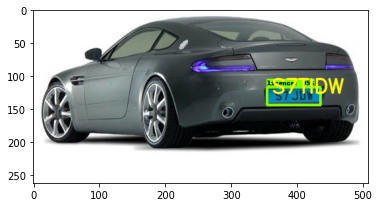


Plate Num:   OPLATECOL
(217, 145)


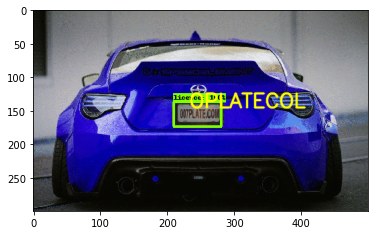


Plate Num:  ON
(56, 171)


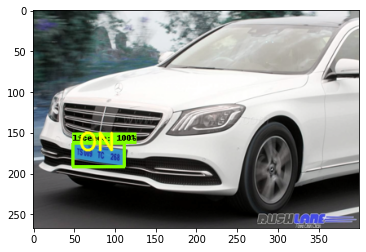

In [ ]:
 for i in img_paths[20:25]:
   img = plate_num_detection(i)
   %matplotlib inline
   plt.figure()
   plt.imshow(img)
   plt.show()